In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm.contrib import tzip
from typing import List, Dict, Tuple, Union
from langchain_ollama import OllamaEmbeddings
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS

c:\Users\jakub\OneDrive\Desktop\PW\Natural Language Processing\SciBot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def hit(found, corr):
    for item in found:
        if item == corr:
            return 1
    return 0


def mrr_f(found, corr):
    for pos, item in enumerate(found):
        if item == corr:
            return 1 / (pos + 1)
    return 0


def dcg(found, corr, num_relevant, k):
    total = 0
    idcg = sum([1 / np.log2(i + 2) for i in range(min(num_relevant, k))])
    for pos, item in enumerate(found):
        total += 1 / np.log2(pos + 2) if item == corr else 0
    return total / idcg


def avg_prec(found, corr, num_relevant):
    total = 0
    for i in range(1, len(found) + 1):
        subset = found[:i]
        cnt = 0
        for item in subset:
            if item == corr:
                cnt += 1
        if subset[-1] == corr:
            total += cnt / len(subset)
    return total / num_relevant

In [3]:
def get_metrics(
    path: str,
    embeddings: Union[OllamaEmbeddings, HuggingFaceInstructEmbeddings],
    texts: List[str],
    metadatas: List[Dict],
    num_relevant: int = 1,
    k: int = 4,
) -> Tuple[float]:
    """
    Calculates hit rate @ 4 and MRR for given queries.
    Input:
        db (str) : Path to saved vectorstore
        embeddings (str) : Embeddings object
        texts (List) : Text of thr queries
        metadatas (List) : Metadata of the queries, used to find matching documents in db
        num_relevant (int) : Number of relevant items in vdb
        k (int) : Number of retrieved documents
    """
    db = FAISS.load_local(
        folder_path=path,
        index_name="faiss_index",
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
    )

    hit_rates = []
    mrr_scores = []
    ndcg_scores = []
    prec_scores = []
    for text, md in tzip(texts, metadatas):
        try:
            vec = embeddings.embed_documents([text])[0]
            found = db.similarity_search_by_vector(vec, k=k)
            # take the metadata from found documents, as the metadata of the modified document (query) is the same as the metadata of the base document (in db)
            # if we find it in the the mds list it means that one of the found documents is the base one which was used to create the modfied document
            mds = [doc.metadata for doc in found]
            hit_rates.append(hit(mds, md))
            mrr_scores.append(mrr_f(mds, md))
            prec_scores.append(avg_prec(mds, md, num_relevant))
            ndcg_scores.append(dcg(mds, md, num_relevant, k))
        except:
            pass

    return (
        np.mean(hit_rates),
        np.mean(mrr_scores),
        np.mean(prec_scores),
        np.mean(ndcg_scores),
    )

In [4]:
def load_document_from_json(filename):
    with open(filename, "r", encoding="utf-8") as f:
        doc_data = json.load(f)
    return Document(page_content=doc_data["page_content"], metadata=doc_data["metadata"])

In [5]:
folder_path = "../../data/mod"
docs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        doc = load_document_from_json(os.path.join(folder_path, filename))
        docs.append(doc)

In [6]:
texts = [doc.page_content for doc in docs]
metadatas = [doc.metadata for doc in docs]
len(texts), len(metadatas)

(100, 100)

In [7]:
url = "http://localhost:11434"
results = []

In [8]:
embeddings = OllamaEmbeddings(base_url=url, model="snowflake-arctic-embed:latest")
hit_rate, mrr, map, ndcg = get_metrics("../../data/dbs/db_snowflake", embeddings, texts, metadatas, num_relevant=1, k=4)
results.append(["snowflake", hit_rate, mrr, map, ndcg])

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


In [9]:
embeddings = OllamaEmbeddings(base_url=url, model="mxbai-embed-large:latest")
hit_rate, mrr, map, ndcg = get_metrics("../../data/dbs/db_mxbai", embeddings, texts, metadatas, num_relevant=1, k=4)
results.append(["mxbai", hit_rate, mrr, map, ndcg])

100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


In [10]:
embeddings = OllamaEmbeddings(base_url=url, model="nomic-embed-text:latest")
hit_rate, mrr, map, ndcg = get_metrics("../../data/dbs/db_nomic", embeddings, texts, metadatas, num_relevant=1, k=4)
results.append(["nomic", hit_rate, mrr, map, ndcg])

100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


In [ ]:
device = "cuda"
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-xl", model_kwargs={"device": device}
)
hit_rate, mrr, map, ndcg = get_metrics("../../data/dbs/db_instructor", embeddings, texts, metadatas, num_relevant=1, k=4)
results.append(["instructorxl", hit_rate, mrr, map, ndcg])

In [13]:
df = pd.DataFrame(results, columns=["model", "hit_rate", "mrr", "map", "ndcg"])
df

,model,hit_rate,mrr,map,ndcg
0,snowflake,0.978723,0.968085,0.968085,0.970871
1,mxbai,0.970000,0.929167,0.929167,0.939544
2,nomic,0.930000,0.901667,0.901667,0.908614
3,instructorxl,0.940000,0.928333,0.928333,0.931309


In [14]:
df.to_csv("../../data/results/embeddings.csv", index=False)

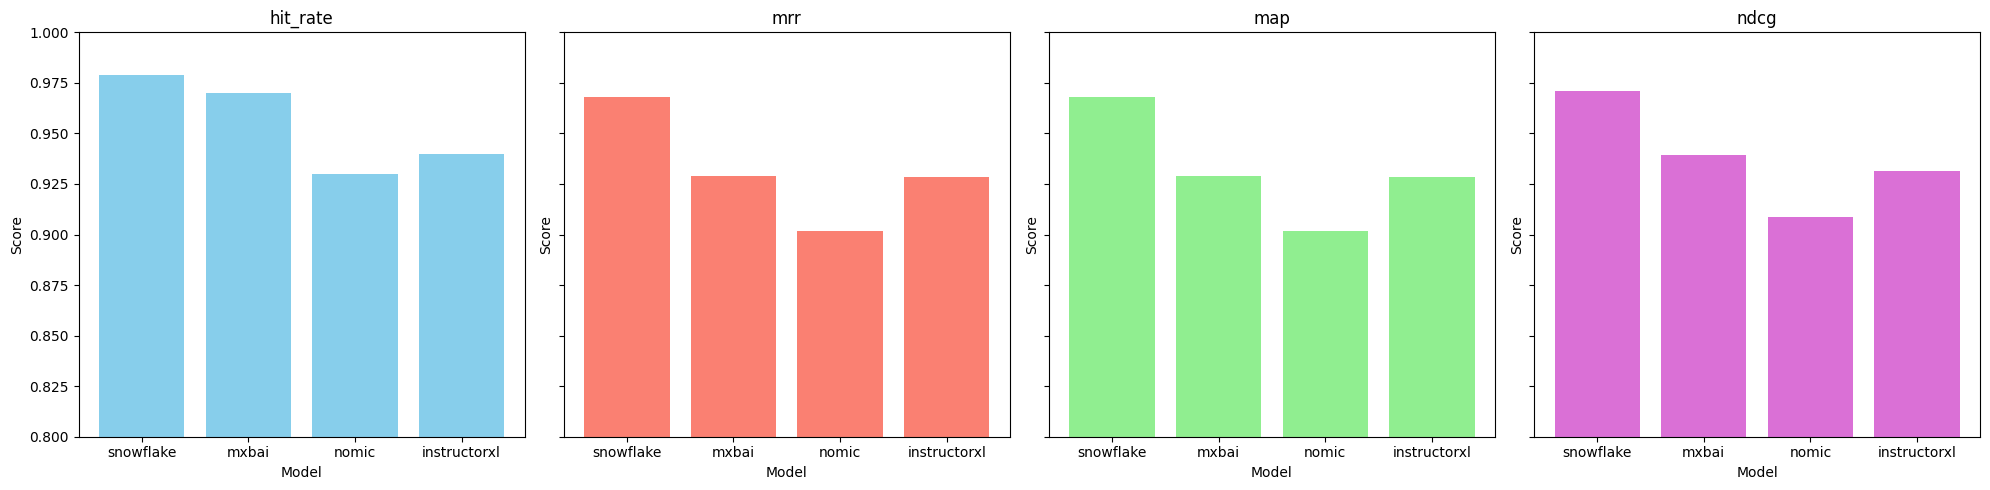

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
metrics = ['hit_rate', 'mrr', 'map', 'ndcg']
colors = ['skyblue', 'salmon', 'lightgreen', 'orchid']

# Create a bar plot for each metric
for i, metric in enumerate(metrics):
    axes[i].bar(df['model'], df[metric], color=colors[i])
    axes[i].set_title(metric)
    axes[i].set_ylim(0.8, 1)  # Set y-axis limits for better comparison
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel('Score')

plt.tight_layout()
plt.show()